In [1]:
import csv
import pandas as pd
import numpy as np
# plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# scikit learn
from sklearn import model_selection
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV, LassoCV

#scipy
from scipy.stats import t

(Q1)
1. Importer la base de données data_dm3.csv disponible depuis le lien 
https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv. 
La dernière colonne est la variable à expliquer. Les autres colonnes sont les variables explicatives. Préciser le nombre de variables explicatives et le nombre d’observations.

In [2]:
url = 'https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv'
df = pd.read_csv(url, header=None)

210 variables explicatives (200 variables explicatives inappropriées)
442 observations

(Q2)

Les variables explicatives sont-elles centrées ? Normalisées ? Qu’en est-il de la variable à expliquer ? Tracer un scatter plot de la base de données avec 4 covariables prises au hasard et la variable à expliquer (un scatterplot regroupe les graphes de chacune des variables en fonction de chacune des autres). Commenter les graphiques obtenus.

In [3]:
X = df.iloc[:,:-1]

is_X_Centered = all(X.mean()<10**-10)
is_X_Normalized = all(round( X.std(ddof=0), 6)==1.0)
is_X_Normalized2 = all(round( X.std(ddof=1), 6)==1.0)


is_X_Centered, is_X_Normalized, is_X_Normalized2

# variables explicatives centrées et normalisées, mais 
# via la formule biaise de la variance (en 1/N) a été utilisée pour la variance


(True, True, False)

In [4]:
y = df[210]

is_y_Centered = y.mean()<10**-10

is_y_Normalized = round(y.std(ddof=0), 6)==1.0

is_y_Centered, y.mean(), is_y_Normalized, y.std()

(False, 152.13348416289594, False, 77.09300453299109)

<Figure size 864x864 with 0 Axes>

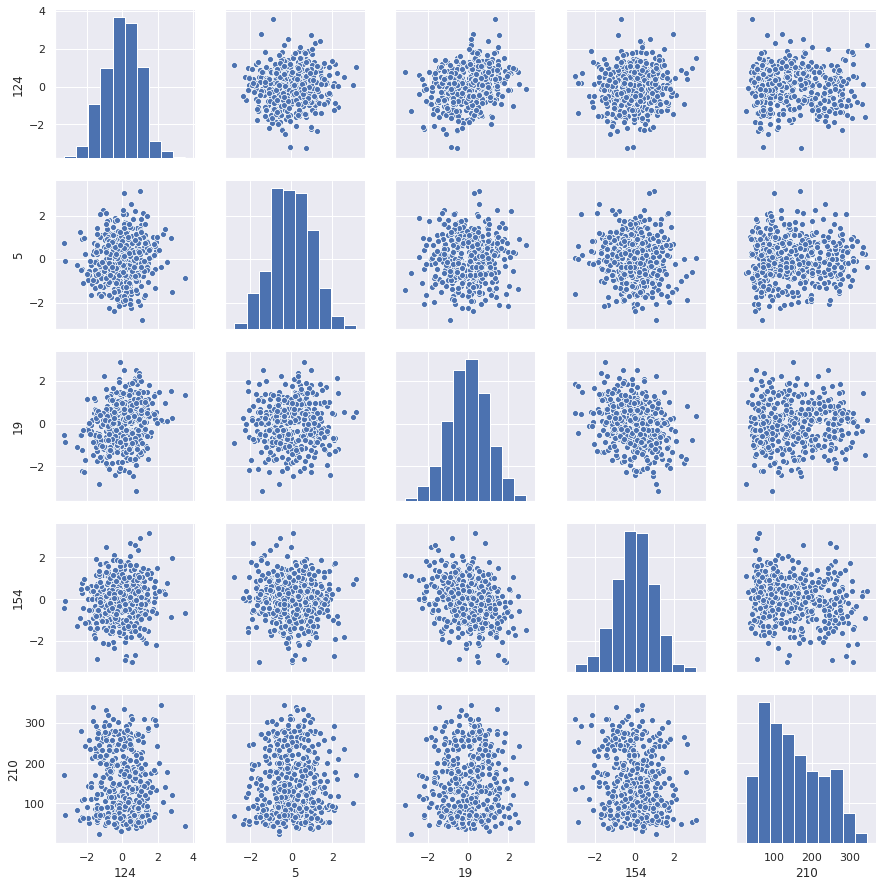

In [5]:
X = df.sample(4,axis =1, random_state = 42 ) # select 4 random covariates 
y = df[210] 

# use sns display mode.
sns.set()

# plot
fig = plt.figure(figsize=(12, 12))
sns.pairplot(data=df[np.append(np.random.randint(0,210,4),210)]) # ajouter la colonne y

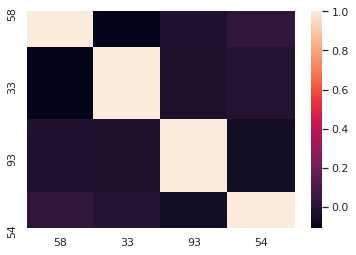

In [6]:
mat_cov = df[np.random.randint(0,210,4)].cov()
sns.heatmap(mat_cov)

# 3 Echantillon d’apprentissage et de test
Echantillon d’apprentissage et de test. Créer 2 échantillons :un pour apprendre le modèle
X train , un pour tester le modèle X test . On mettra 20% de la base dans l’échantillon ’test’.
Donner les tailles de chacun des 2 échantillons. On notera que le nouvel échantillon de
covariables X train n’est pas normalizé. Dans la suite, on fera donc bien attention à inclure l’intercept dans nos régression.

In [7]:
X_train, X_test, y_train, y_test= model_selection.train_test_split(df[range(0,210)], df[210], test_size=0.2, random_state=1)

In [8]:
f"taille de x_train est {X_train.shape} et de X_test est {X_test.shape}"

'taille de x_train est (353, 210) et de X_test est (89, 210)'

In [9]:
round(X_train.std(),6) ==1.0
 
X_train.mean()<10**-10

0       True
1       True
2       True
3      False
4      False
       ...  
205     True
206    False
207    False
208    False
209    False
Length: 210, dtype: bool

# 4

Donner la matrice de covariance calculée sur X train. Tracer le graphe de la décroissance des valeurs propres de la matrice de covariance (ou de corrélation). Expliquer pourquoi il est légitime de ne garder que les premières variables de l’ACP. On gardera 60 variables dans la suite.

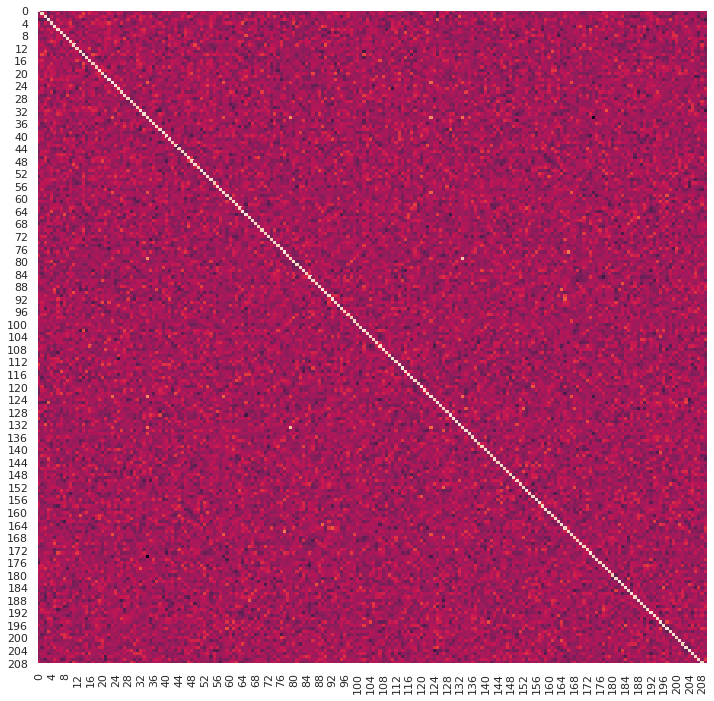

In [10]:
mat_cov_xtrain=X_train.cov()

plt.figure(figsize=(12, 12))
sns.heatmap(data = mat_cov_xtrain, cbar = False)

In [11]:
U,S,V = np.linalg.svd(mat_cov_xtrain)

Text(0.5, 1.0, 'Graphe de décroissance des valeurs propres')

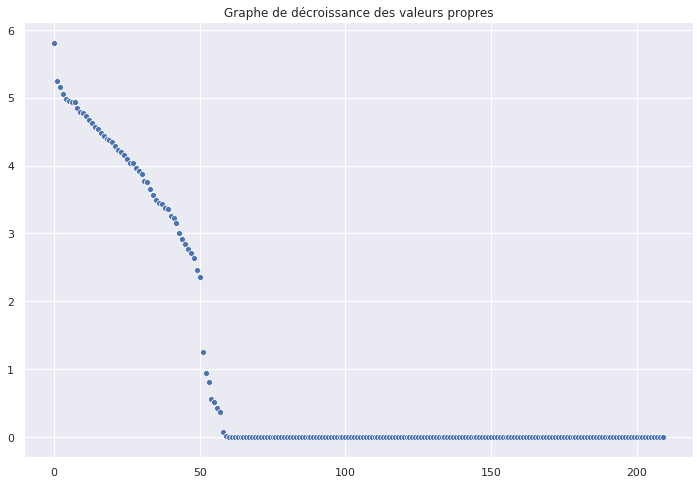

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = sns.scatterplot(range(210), S)
ax.set_title('Graphe de décroissance des valeurs propres')

## affiner l'axe des abscisses par pas de 10

**on se rend compte que seules les 60 premieres valeurs singulieres ont une valeur significative.
les suivantes sont négligeables.**

5. Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS"
qui consiste à appliquer OLS avec Y et X train V (1:60) , où V (1:60) contient les vecteurs propres
(associés aux 60 plus grandes valeurs propres) de la matrice de covariance. Faire une 
régression linéaire (avec intercept), puis tracer les valeurs des coefficients (hors intercept).
Sur un autre graphique, faire de même avec la méthode des moindres carrés classique.

In [13]:
# PCA
pca_60 = PCA(n_components=60)

Xtildetrain=pca_60.fit_transform(X_train)
Xtildetest=pca_60.fit(X_train).transform(X_test)


Text(0.5, 1.0, 'coefficients du modèle de PCA before OLS')

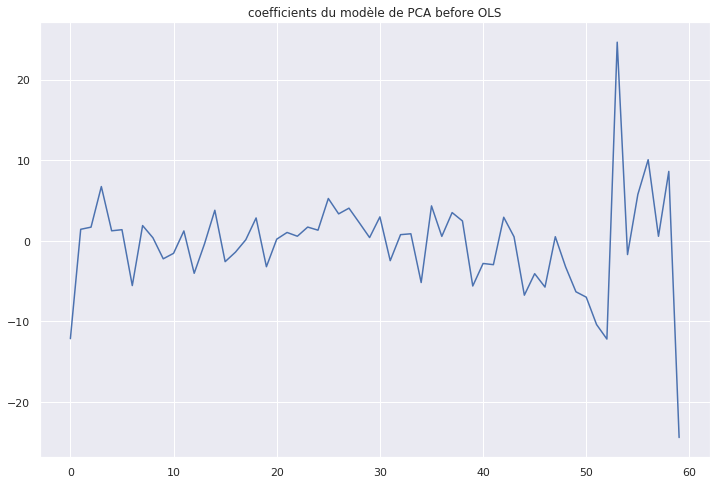

In [14]:
# hyperparameters : with intercept
model_lin_pca = lm.LinearRegression()
model_lin_pca.fit(Xtildetrain, y_train)

fig = plt.figure(figsize=(12, 8))
ax = sns.lineplot(range(60), model_lin_pca.coef_)
ax.set_title('coefficients du modèle de PCA before OLS')

Text(0.5, 1.0, 'coefficients du modèle OLS classique')

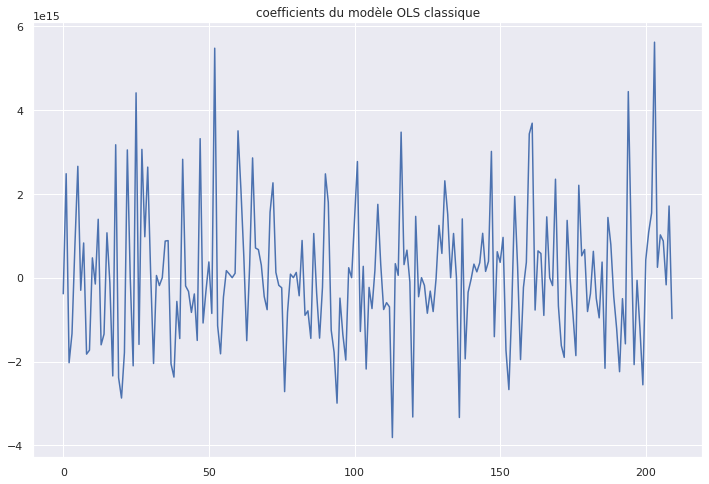

In [15]:
#OLS classique
model_lin = lm.LinearRegression(fit_intercept=True)
model_lin.fit(X_train, y_train)


fig = plt.figure(figsize=(12, 8))
ax = sns.lineplot(range(210), model_lin.coef_)
ax.set_title('coefficients du modèle OLS classique')

en observant les échelles en ordonnées, on voit que les coefficients explosent si on fait la OLS classique sans PCA (ordre de grandeur de 10**15),
Les coefficients sont biens plus réguliers avec une PCA Before OLS

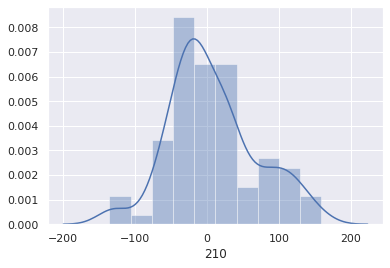

In [16]:
prediction_PCA_OLS = model_lin_pca.predict(Xtildetest)
prediction_OLS = model_lin.predict(X_test)

sns.distplot(y_test - prediction_PCA_OLS)

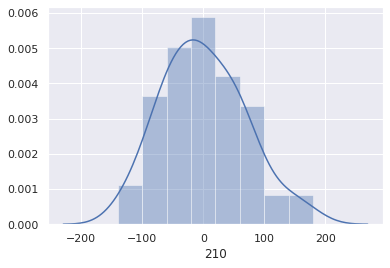

In [17]:
sns.distplot(y_test - prediction_OLS)

6 Donner les valeurs des intercepts pour les 2 régressions précédentes. Donner la valeur
moyenne de la variable Y (sur le train set). Les intercepts des 2 questions sont-ils égaux ?
Commenter. Uniquement pour cette question, centrer et réduire les variables après ACP
(de petite dimension). Faire une régression avec ces variables et vérifier que l’intercept est
bien égal à la moyenne de Y sur le train.

In [18]:
print(f" intercept pour le modèle de PCA before OLS = {model_lin_pca.intercept_} ")
print(f" intercept pour le modèle de OLS classique = {model_lin.intercept_} ")

 intercept pour le modèle de PCA before OLS = 153.37677053824362 
 intercept pour le modèle de OLS classique = 152.47052053824362 


les intercepts ne sont pas égaux.  ### continuer

In [19]:
y_train_mean = y_train.mean()

print(f" valeur moyenne de y_train = {y_train_mean} ")

 valeur moyenne de y_train = 153.37677053824362 


In [20]:
scaled = scale(X_train, with_mean=True, with_std=False)

In [21]:
model_lin_pca.intercept_ == y_train_mean

True

une fois les variables après ACP centrées et réduites,  l'intercept de la régression est égal à  la moyenne de y_train

(7)

Pour les 2 méthodes (OLS et PCA before OLS) : Tracer les résidus de la prédiction sur
l’échantillon test. Tracer leur densité (on pourra par exemple utiliser un histogramme).
Calculer le coefficient de détermination sur l’échantillon test. Calculer le risque de prédiction
sur l’échantillon test.

Text(0.5, 1.0, "résidus de la prédiction sur l'échantillon test")

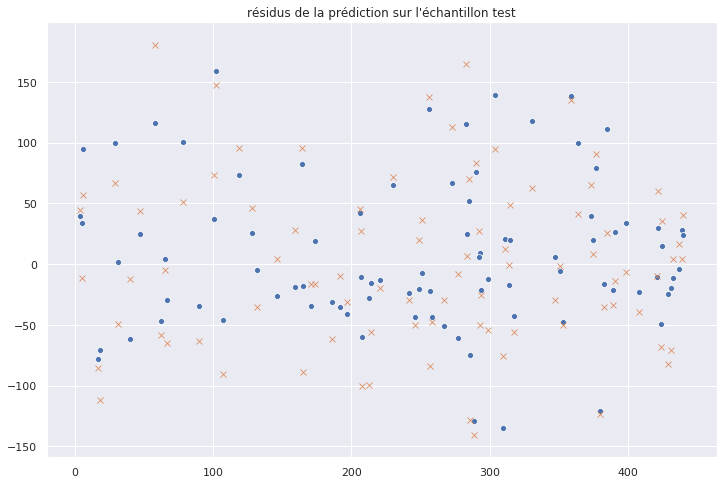

In [22]:
residus_PCA_OLS = y_test - model_lin_pca.predict(Xtildetest)
residus_OLS = y_test - model_lin.predict(X_test)

fig = plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=residus_PCA_OLS)
ax = sns.scatterplot(data = residus_OLS, marker = 'x')
ax.set_title('résidus de la prédiction sur l\'échantillon test')

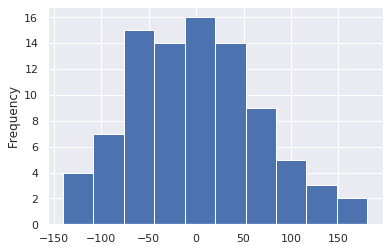

In [23]:
residus_OLS.plot.hist()

In [24]:
#coefficients de détermination sur l'échantillon test
score_PCA_OLS = model_lin_pca.score(Xtildetest,y_test)
score_OLS = model_lin.score(X_test,y_test)

print("coefficients de détermination pour :")
print(f"Le modèle de PCA before OLS = {score_PCA_OLS} ")
print(f"Le modèle de OLS classique = {score_OLS} ")

coefficients de détermination pour :
Le modèle de PCA before OLS = 0.2984760669257362 
Le modèle de OLS classique = 0.1229310049463892 


In [25]:
#risque de prédiction sur l'échantillon test
MSE_PCA_OLS = mean_squared_error(model_lin_pca.predict(Xtildetest),y_test)
MSE_OLS = mean_squared_error(model_lin.predict(X_test),y_test)

print("coefficients de détermination pour :")
print(f"Le modèle de PCA before OLS = {MSE_PCA_OLS} ")
print(f"Le modèle de OLS classique = {MSE_OLS} ")

coefficients de détermination pour :
Le modèle de PCA before OLS = 3738.4002265608974 
Le modèle de OLS classique = 4673.874653782992 


Coder la méthode de forward variable sélection. On pourra utiliser la statistique du test de nullité du coefficient (comme vu en cours). Pour l’instant, on ne met pas de critère d’arret sur la méthode. C’est à dire que l’on ajoute une variable à chaque étape jusqu’à retrouver la totalité des variables. Afficher l’ordre de séléction des variables.

In [26]:
X_k_ = X_train[[2]]
X_k = np.hstack((np.ones((len(X_k_),1)),X_k_))

#XtX = ((X_k_ - X_k_.mean())**2).sum()

XtX = (X_k.transpose() @ X_k) 

XtX_inv = np.linalg.inv(XtX)[1][1]

#1/XtX

len(X_k)

353

In [71]:
list_columns=[]
for k in X_train.columns:
    list_columns.append(k)

#t_stats = []
#pvals = []
X_ordered = []

y = y_train
p_val_min_indexes = []
p_val_mins =[]

t_stat_columns=[]
t_stat_max_indexes=[]
t_stat_maxs =[]

j=0

for i in range(len(list_columns)):

    t_stats = []
    pvals = []
    
    for k in list_columns:
        
        if k in t_stat_max_indexes:
            T_stat = 0
            
        else:
        
            X_k_=X_train[[k]]
        
            n = len(X_k_)
            X_k = np.hstack((np.ones((len(X_k_),1)),X_k_))

            XtX = X_k.transpose() @ X_k 

            XtX_inv = np.linalg.inv(XtX)

            reglin = lm.LinearRegression(fit_intercept = True)
            reglin.fit(X_k_, y)

            ychap=reglin.predict(X_k_) 

            sigma_squarred = np.sum((y-ychap)**2)/ (n-2)
            sigma = np.sqrt(sigma_squarred)

            T_stat = abs(reglin.coef_[0])/(sigma*np.sqrt(XtX_inv[1][1]))
            
        t_stats.append(T_stat)
        
    t_stat_columns.append(t_stats)
    
    #select max value of pvals
    T_stat_max = max(t_stats)
    
    t_stat_maxs.append(T_stat_max)
    
    pval_min = (1 - t.cdf(abs(T_stat_max), n-2)) * 2
    
    
    p_val_mins.append(pval_min)
    
    t_stat_max_index = t_stats.index(T_stat_max)
    t_stat_max_indexes.append(t_stat_max_index)
    
    #select the X_k associated to that variable
    X_selected_ = X_train[[t_stat_max_index]]
    
    #X_selected = np.hstack((np.ones((len(X_selected_),1)),X_selected_))
    
    #add selected X_k in the list of X
    #X_ordered.append(X_selected)

    reglin1 = lm.LinearRegression(fit_intercept = True)
    reglin1.fit(X_selected_, y)
    
    #calculate residual
    y = y - reglin1.predict(X_selected_)

    #delete the element selected    
    #del list_columns[p_val_min_index]
    

In [61]:
p_val_mins

[0.0,
 6.483702463810914e-13,
 0.012159822103626539,
 0.015999517447039535,
 0.024121345107332104,
 0.016424279755665516,
 0.02766249668694054,
 0.051054786699444854,
 0.03984369609434091,
 0.06907343981981162,
 0.08587337923872385,
 0.05303019543717635,
 0.10191400288334584,
 0.11148043183198797,
 0.07898568681845264,
 0.12449031333579152,
 0.18173087052662762,
 0.2161316113802454,
 0.24064246613321583,
 0.2538747869415823,
 0.3646754685299305,
 0.34207956930400596,
 0.39861911043416987,
 0.35499350594413004,
 0.42035154164885435,
 0.42641130009006956,
 0.4102813598570756,
 0.4261536873138121,
 0.432860737577645,
 0.4840786995737987,
 0.49217995010189863,
 0.5341636020195741,
 0.5616271201458498,
 0.5860881822249175,
 0.5911606381943246,
 0.5458460690712421,
 0.6476114864292368,
 0.615943158102439,
 0.6676255448740103,
 0.7015752422814225,
 0.6806201931602125,
 0.7369434279009794,
 0.7212585780246179,
 0.7519821932063735,
 0.7828204266420316,
 0.8060668572253822,
 0.8008533415348498,


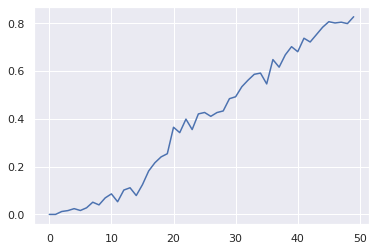

In [74]:
print(f"ordre de sélection de variables sans critère d'arrêt:{t_stat_max_indexes}")

ordre de sélection de variables sans critère d'arrêt:[58, 123, 84, 172, 43, 187, 110, 14, 208, 133, 41, 87, 112, 34, 135, 167, 156, 115, 45, 134, 77, 11, 176, 102, 111, 174, 99, 50, 30, 169, 131, 170, 97, 79, 75, 186, 33, 10, 142, 73, 193, 188, 151, 85, 204, 60, 23, 19, 116, 65, 129, 198, 64, 5, 55, 168, 157, 144, 109, 7, 171, 18, 184, 178, 62, 104, 117, 159, 21, 6, 38, 0, 127, 120, 47, 13, 96, 200, 147, 81, 29, 139, 166, 150, 124, 74, 59, 27, 196, 69, 90, 113, 44, 12, 91, 126, 130, 137, 24, 28, 46, 15, 57, 36, 70, 78, 192, 190, 107, 37, 132, 143, 138, 164, 201, 32, 165, 148, 88, 83, 162, 20, 31, 118, 103, 17, 121, 26, 100, 1, 149, 25, 175, 89, 66, 145, 140, 141, 9, 202, 177, 67, 106, 122, 155, 197, 86, 98, 161, 101, 206, 80, 2, 52, 16, 114, 152, 153, 49, 185, 61, 40, 95, 42, 189, 191, 154, 8, 54, 39, 179, 76, 119, 82, 182, 125, 181, 199, 71, 160, 4, 51, 180, 63, 53, 93, 22, 94, 207, 195, 194, 136, 56, 128, 92, 158, 68, 146, 163, 203, 72, 3, 48, 205, 35, 173, 183, 108, 105, 209]


(Q9)
Critère d’arrêt : On décide d’arrêter lorsque la p-valeur dépasse 0.1. Illustrer la méthode en donnant (i) les 3 graphes des statistiques obtenues lors de la sélection de la 1er, 2eme et 3eme variables (en abscisse : l’index des variables, en ordonné : la valeur des stats) , (ii) le graphe des 50 premières p-valeurs (dont chacune est associée à la variable sélectionnée). Sur ce même graphe, on tracera la ligne horizontale d’ordonnée 0.1. Enfin on donnera la liste des variables sélectionnées.

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(range(210),t_stat_columns[0])
sns.lineplot(range(210),t_stat_columns[1])
sns.lineplot(range(210),t_stat_columns[2])

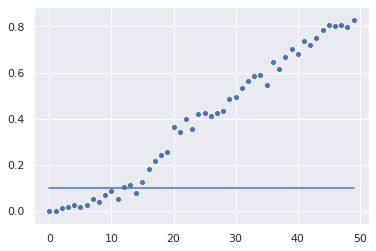

In [80]:
ax = sns.scatterplot(range((50)), p_val_mins[:50]), sns.lineplot(range(50),0.1)


(Q10)
Appliquer OLS sur les variables sélectionnées. Donner le risque de prédiction obtenu l’échantillon test et le comparer à ceux de OLS et PCA before OLS.

11. Afin de préparer la validation croisée, séparer l’échantillon train en 4 parties (appelées
”folds”) de façon aléatoire. On affichera les numéros d’échantillon sélectionnés dans chaque
fold.

In [ ]:
X_train

In [ ]:
kf = KFold(n_splits=4)

fold1,fold2,fold3,fold4 = kf.split(X_train)

print(fold1)
print(fold2)
print(fold3)
print(fold4)

12
Appliquer la méthode de la régression ridge. Pour le choix du paramètre de régularisation,
on fera une validation croisée sur les ”folds” définies lors de la question précédente. A
tour de rôle chacune des ”folds” servira pour calculer le risque de prédiction alors que
les autres seront utilisées pour estimer le modèle. On moyennera ensuite les 4 risques de
prédictions. On donnera la courbe du risque de validation croisée en fonction du paramètre
de régularisation (on veillera à bien choisir l’espace de définition pour le graphe). Donner
le paramètre de régularisation optimal et la valeur du risque sur le test

In [ ]:
risque_cv=[]
for alpha in range(1,250):
    risque_pred = []
    for train_index, test_index in kf.split(X_train):
        X_train_CV, X_test_CV = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_CV, y_test_CV = y_train.iloc[train_index], y_train.iloc[test_index]
        ridge = Ridge(alpha = alpha).fit(X_train_CV,y_train_CV)
        risque_pred.append(mean_squared_error(ridge.predict(X_test_CV),y_test_CV))
    risque_moyen= np.array(risque_pred).mean()
    risque_cv.append(risque_moyen)

    

In [ ]:
sns.lineplot(range(249),risque_cv)

In [ ]:
risque_cv.index(min(risque_cv))

(Q13)
A l’aide de la fonction lassoCV de sklearn, choisir le paramètre de régularisation du LASSO. Donner le risque de prédiction associé.

In [ ]:
lasso = LassoCV()

In [ ]:
lasso.fit(X_train, y_train)

In [ ]:
regularization_param = lasso.alpha_
MSE_Lasso = mean_squared_error(lasso.predict(X_train), y_train)

print(f"- paramètre de régularisation du LASSO: {regularization_param}- risque de prédiction associé : {MSE_Lasso}")



(Q14)
Donner les variables selectionées par le lasso. Combien y-en a t-il ? Appliquer la méthode OLS aux variables sélectionnées. Cette méthode est appelé Least-square LASSO

In [ ]:
variable_lasso = np.nonzero(lasso.coef_)[0]

In [ ]:
lr_lasso = lm.LinearRegression()

In [ ]:
lr_lasso.fit(X_train[variable_lasso],y_train)

In [ ]:

MSE_Lr_lasso = mean_squared_error(lr_lasso.predict(X_test[variable_lasso]), y_test)

print(f"risque de prrédiction associé : {MSE_Lr_lasso}")
